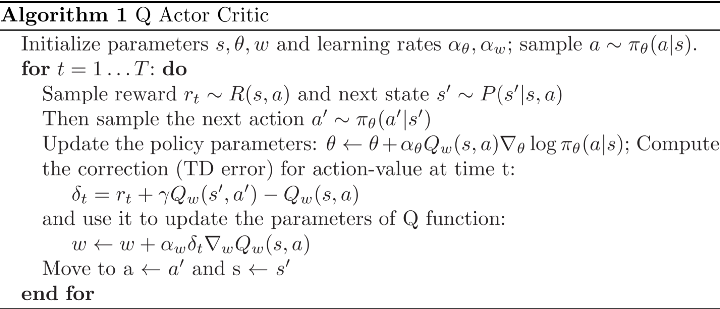

https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f



In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import copy

NUM_EPISODES = 4000
LEARNING_RATE = 0.0029
learning_rate = 0.05
GAMMA = 0.99
max_steps = 200 #force cartpole-v0 steps per episode

In [2]:
env = gym.make('CartPole-v1')
print(env.reset())
print(env.step(0)[0])
actions = [0,1]

(array([ 0.00752086, -0.01726747, -0.02619763, -0.04882263], dtype=float32), {})
[ 0.00717551 -0.21200417 -0.02717408  0.23548096]


In [3]:
import numpy as np
#rbf
from sklearn.kernel_approximation import RBFSampler

def gather_samples(env, n_episodes=10000):
    samples = []
    for _ in range(n_episodes):
        s = env.reset()[0]
        done = False
        while not done:
            a = env.action_space.sample()
            #print(s)
            sa = np.concatenate((s, [a]))
            samples.append(sa)

            s, r, done, _f, _ = env.step(a)
    return samples

class q_hat_class:
    """
    this is our linear function approximator
    hark back to the example given above from sutton's own site for guidance
    
    """
    def __init__(self, env):
        # fit the featurizer to data
        self.env = env
        
        #get samples to train the rbf
        samples = gather_samples(env)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.n_components

        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s, a):
        sa = np.concatenate((s[0], [a]))
        x = self.featurizer.transform([sa])
        return x @ self.w


    def grad(self, s, a):
        sa = np.concatenate((s[0], [a]))
        x = self.featurizer.transform([sa])
        return x  

    def update(self, s, a, t, alpha): #def of alpha here allows for it to change
        # update the model
        g = self.grad(s, a)
        err = t - self.predict(s, a)
        self.w += alpha * err * g

In [4]:
qhat = q_hat_class(env)

In [5]:


# noinspection PyMethodMayBeStatic
class Agent:
    def __init__(self, qhat, actions):
        self.poly = PolynomialFeatures(1)
        self.w= np.random.rand(5, 2) * 0.01
        self.qhat = qhat
        self.actions = actions
        

    def policy(self, state):
        z = state.dot(self.w)
        exp = np.exp(z)
        return exp/np.sum(exp)

    def __softmax_grad(self, softmax):
        s = softmax.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    def grad(self, probs, action, state):
        dsoftmax = self.__softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = state.T.dot(dlog[None,:])
        return grad
    
    def state_value(self, state):
        z = state.dot(self.w)
        

    def update_with(self, reward, probs, action, state, next_state, next_action, done, action_space):
        
        #update policy params
        q_pred = self.qhat.predict(state, action)
        grad = self.grad(probs, action, self.poly.fit_transform(state))
        self.w += LEARNING_RATE * q_pred * grad
          
        #qhat update         
        if done:
            next_state_discounted = 0
        else:
            next_state_discounted = GAMMA * self.qhat.predict(next_state, next_action)
                       
        err = reward + next_state_discounted - self.qhat.predict(state, action)        
        grad = self.qhat.grad(state, action)
        self.qhat.w += learning_rate * err * np.squeeze(grad)


In [6]:
agent = Agent(qhat, actions)

In [7]:
def main(agent, train = 1, env = gym.make('CartPole-v0'), LEARNING_RATE = 0.0029, learning_rate = 0.05):
    env = env
    np.random.seed(1)
    LEARNING_RATE = LEARNING_RATE
    learning_rate = learning_rate
    action_space = env.action_space.n
    
    complete_scores = []

    for e in range(NUM_EPISODES):
        score = 0 
        steps = 0
        
        state = env.reset()[0][None, :]
        #state = agent.poly.fit_transform(state)
        #need to pick initial action here

        while True:
            
            probs = agent.policy(agent.poly.fit_transform(state))
            action = np.random.choice(action_space, p=probs[0])
            
            
            if train:
                #take action, sample reward
                next_state, reward, done, _f, _ = env.step(action)
                next_state = next_state[None,:]
                #select next action
                next_probs = agent.policy(agent.poly.fit_transform(next_state))
                next_action = np.random.choice(action_space, p=next_probs[0])
                
                #update policy params                         
                agent.update_with(reward, probs, action, state, next_state, next_action, done, action_space) #change to take next action
                
                probs = next_probs
                action = next_action
                            
            else:
                action = np.argmax(probs[0])
                next_state, reward, done, _f, _ = env.step(action)
                next_state = next_state[None,:]
                
            score += reward            
            state = next_state

            #add action = next_action
            
            if steps == max_steps:
                done = True
            else:
                steps += 1

            if done:
                break
            
        complete_scores.append(score)
        
        if train:
                
            if np.mean(complete_scores[-20:]) >= 195:
                print("convergence has been attained")
                break
                         
    env.close()
    plt.plot(np.arange(len(complete_scores)),
             complete_scores)
    plt.show()
    
    return agent

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


convergence has been attained


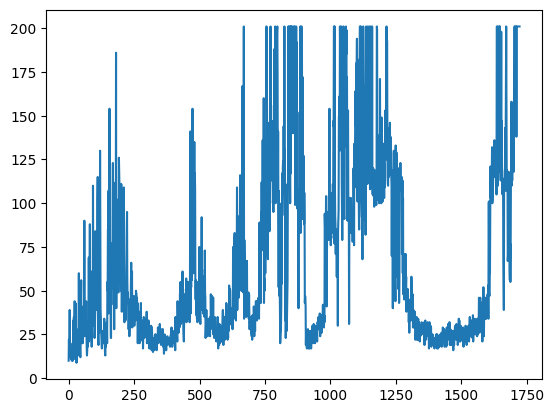

In [8]:
trained_agent = main(agent, 1, env , LEARNING_RATE, learning_rate)


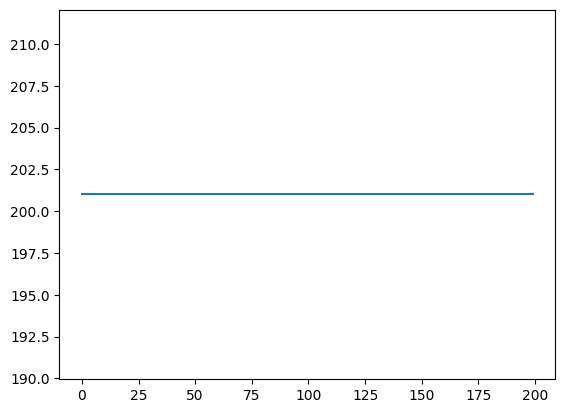

In [9]:
NUM_EPISODES = 200

trained_agent = main(trained_agent, 0, env)
